In [37]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import typing
from scipy.stats import poisson

In [38]:
opp_stats = pd.read_csv('opponent_stats.csv',index_col=0)
schedule = pd.read_csv('schedule.csv',index_col=0)
game_logs_playoffs_df = pd.read_csv('pdata.csv')
game_logs_df = pd.read_csv('data_test.csv')

pdata = pd.read_csv('pdata.csv')
pdata['season'] = pdata['date'].apply(lambda x: x.split('-')[0])
data = pd.read_csv('data_2024.csv')
data23 = pd.read_csv('data_2023.csv')
data = pd.concat((data,data23))
data = pd.concat((pdata,data))
data= data.sort_values(by=['player','date']).reset_index(drop=True)

In [39]:
today = dt.datetime.today()
year = today.year
month = today.month
day = today.day
today_str = f'{year}_{month}_{day}'

In [40]:
pp_lines = pd.read_csv(f'Lines/pp/pp_{today_str}.csv',index_col=0)
unabated = pd.read_csv(f'Lines/unabated/unabated_{today_str}.csv',index_col=0)

In [41]:
pp_lines.head(2)

,player,team,line,stat,opp,league_id,league_name,event_time,pp_player_id,date,time,prop_id
0,Chris Boswell + Nick Folk,PIT/TEN,0.5,FG Made (Combo),TEN/PIT,245,NFL1Q,2023-11-02 19:15:00-05:00,175560,2023-11-02 19:15:00-05:00,2023-11-02 16:33:00,683037f7-b
1,Alex DeBrincat + Aleksander Barkov,DET/FLA,0.5,Goals (Combo),FLA/DET,8,NHL,2023-11-02 18:00:00-05:00,175543,2023-11-02 18:00:00-05:00,2023-11-02 16:33:00,6a435226-6


In [42]:
import pandas as pd
from scipy.stats import poisson
import matplotlib.pyplot as plt


def load_current_line(path, key, time) -> pd.DataFrame:
    df = pd.read_csv(path, index_col=0).sort_values(by=time, ascending=False)
    return df.groupby(key).first().reset_index()


def get_line(player, pp_stat, lines):
    guy = lines.loc[lines["player"] == player]
    pt_lines = guy.loc[guy["stat"] == pp_stat]
    return pt_lines


class GameLog:
    def __init__(self, df):
        self.game_log = df
        self.game_log["date"] = pd.to_datetime(self.game_log["date"], format="%Y-%m-%d")
        self.game_log["rest"] = self.game_log.groupby("player")["date"].diff().dt.days
        self.game_log = self.game_log.fillna(5)

    def get_stat(self, player, category) -> list[float]:
        stats = self.game_log
        stats = stats.loc[stats["player"] == player]
        x = category.split("+")
        points = stats[x[0]]
        for i in range(len(x) - 1):
            points = points + stats[x[i + 1]]
        return points.to_list()

    def moving_avg(self, player, cat, window_size=10) -> pd.Series:
        # getting relevant stat category series
        data = self.game_log
        data = data.loc[data["player"] == player]
        x = cat.split("+")
        total = data[x[0]]

        # summing if category is multi stat
        for i in range(len(x) - 1):
            total = total + data[x[i + 1]]
            print(i)
        moving = total.rolling(window=window_size, min_periods=1).mean()
        return moving.reset_index(drop=True)

    def get_stat(self, player, category, stats=None) -> pd.Series:
        stats = self.game_log
        stats = stats.loc[stats["player"] == player]
        x = category.split("+")
        points = stats[x[0]]
        for i in range(len(x) - 1):
            points = points + stats[x[i + 1]]
        return points

    def print_prob(self, player, line, cat, stats=None, games=None) -> None:
        stats = self.game_log
        if games == None:
            series = self.get_stat(player, cat, stats).reset_index(drop=True)
        else:
            series = self.get_stat(player, cat, stats)[-games:]
        p = (series > line).sum()
        n = len(series)
        print(
            f"{player} hits the {cat} line {p}/{n} times or", round(100 * p / n, 2), "%"
        )
        return

    def dynamic(self, guy, cat, span=8) -> pd.Series:
        stats = self.game_log
        series = self.get_stat(guy, cat, stats)
        return series.ewm(span=span).mean()  # hyperparam

    def get_game(self, player, date, stats=None) -> pd.DataFrame:
        stats = self.game_log
        mask = stats["date"] == pd.Timestamp(date)
        return stats.loc[(stats["player"] == player) & mask]

    def get_pos(self, guy) -> str:
        stats = self.game_log
        return stats.loc[stats["player"] == guy]["pos"].values[0]

    def get_rolling_hit_rate(self, player, line, cat, last_n=None) -> float:
        # need to fix eventually to account for szn
        stats = self.game_log
        if last_n == None:
            window = len(stats)
        else:
            window = last_n
        series = self.get_stat(player, cat, stats)
        hit_rate = (series > line).rolling(window=window, min_periods=1).mean() * 100
        return hit_rate

    def graph_stat(self, player, cat, window, lines) -> None:
        #color and marker keys for graph
        season_colors = {
            0: "#FFB632",
            1: "#007F94",
            2: "#EED78D",
            3: "#C22B26",
            4: "#7D48B2",
        }

        series_markers = {
            "WC1": "^",  # Circle marker
            "WCS": "^",  # Triangle marker
            "WCF": "^",  # Square marker
            "FIN": "^",  # X marker
            5: "o",
        }
        num_games = 82

        mov = self.moving_avg(player, cat, window)
        points = self.get_stat(player, cat)
        player_lines = get_line(player, cat, lines)
        player_df = self.game_log.loc[self.game_log.player == player].reset_index(drop=True)
        player_df['stat_val'] = points.values
        player_df['mov'] = mov.values
        player_df= player_df.iloc[-num_games:].reset_index(drop=True)

        print(cat)
        if player_lines.empty == False:
            line = player_lines["line"].iloc[0]
            print("line:", line)
            self.print_prob(player, line, cat)
            self.print_prob(player, line, cat, games=10)
            plt.axhline(line, color="r", linestyle="--", label="line")
        print("avg:", round(points.mean(), 1))
        x = range(len(points))

        #plotting different marker and color by season/playoffs
        for (season, series), group in player_df.groupby(["season", "series"]):
            color = season_colors.get(int(season) % 5, "blue")
            marker = series_markers.get(series, "^")
            plt.scatter(group.index, group["stat_val"], color=color, marker=marker)

        #plotting moving avg, line, season avg.
        plt.plot(player_df.index, player_df.stat_val, color="g", linestyle=(0, (1, 6)))  # game line
        plt.plot(player_df.index, player_df.mov, label="moving average")  # moving average
        plt.axhline(player_df.loc[player_df.season==2024].stat_val.mean(), color="y", linestyle="-", label="season average")
        plt.ylabel(cat)
        plt.xlabel("Game #")
        plt.title(player)
        plt.legend()
        plt.show()
        return

    def home_adjust(self, cat, home) -> float:
        stats = self.game_log
        cat = cat.split("+")
        seasonstats = stats[cat].mean()
        if home == 1:
            homestats = stats.loc[stats["H/A"] == 1][cat].mean()
            x = homestats.sum() / seasonstats.sum()
        else:
            awaystats = stats.loc[stats["H/A"] == 0][cat].mean()
            x = awaystats.sum() / seasonstats.sum()
        return x

    def best_odds(self, lines, schedule) -> pd.DataFrame:
        data = self.game_log
        date = pd.Timestamp(lines["date"].iloc[0]).strftime("%Y-%m-%d")
        home_teams = schedule.loc[schedule["date"] == date]["home"].values
        player_lines = lines.iloc[:, 0]
        player_idx = data["player"].unique()
        vals = []
        for i in range(len(player_lines)):
            player = lines["player"].iloc[i]
            if player in player_idx:
                cat = lines["stat"].iloc[i]
                opp = lines["team"].iloc[i]
                line = lines["line"].iloc[i]
                if opp in home_teams:
                    home = 0
                else:
                    home = 1
                series = self.get_stat(player, cat)
                season = self.get_rolling_hit_rate(player, line, cat)
                l_10 = self.get_rolling_hit_rate(player, line, cat, last_n=10)
                avg = series.mean()
                mov_avg = self.dynamic(player, cat).iloc[-1]
                expected = mov_avg * self.home_adjust(cat,home)  # adjust(player,cat,opp,avail)
                vals.append(
                    [
                        player,
                        opp,
                        home,
                        cat,
                        round(avg, 1),
                        round(mov_avg, 1),
                        round(expected, 1),
                        line,
                        l_10.iloc[-1],
                        season.iloc[-1],
                    ]
                )
        odd = pd.DataFrame(
            vals,
            columns=[
                "player",
                "opp",
                "home",
                "stat",
                "season_avg",
                "mov_avg",
                "expected",
                "line",
                "last_10",
                "season",
            ],
        )
        odd["blend"] = odd[["last_10", "season"]].mean(axis=1)
        odd["prob"] = 1 - poisson.cdf(mu=odd["expected"], k=odd["line"])
        return odd

gl = GameLog(data)
gl.best_odds(pp_lines,schedule)

,player,opp,home,stat,season_avg,mov_avg,expected,line,last_10,season,blend,prob
0,Anthony Lamb,New Zealand Breakers,1,PTS,6.6,3.4,3.4,16.5,0.0,6.349206,3.174603,1.250872e-07
1,Joel Embiid,PHI,0,PTS,29.3,28.5,28.2,14.5,90.0,93.965517,91.982759,9.975445e-01
2,Joel Embiid,PHI,0,PTS+TRB+AST,43.5,45.0,44.4,22.5,100.0,98.275862,99.137931,9.998451e-01
3,Joel Embiid,PHI,0,TRB,10.5,10.9,10.7,10.5,40.0,50.000000,45.000000,5.038509e-01
4,Joel Embiid,PHI,0,ORB,1.8,1.6,1.6,1.5,40.0,52.586207,46.293103,4.750691e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
1102,Tre Jones,SAS,1,PTS+AST,19.2,17.6,17.9,13.5,80.0,83.333333,81.666667,8.522383e-01
1103,Tre Jones,SAS,1,PTS,12.7,11.3,11.5,7.5,80.0,84.722222,82.361111,8.862655e-01
1104,Tre Jones,SAS,1,PTS+TRB,16.3,15.2,15.4,10.5,90.0,83.333333,86.666667,8.997188e-01
1105,Tre Jones,SAS,1,PTS+TRB+AST,22.8,21.5,21.8,16.5,80.0,83.333333,81.666667,8.747095e-01


MP
avg: 36.5


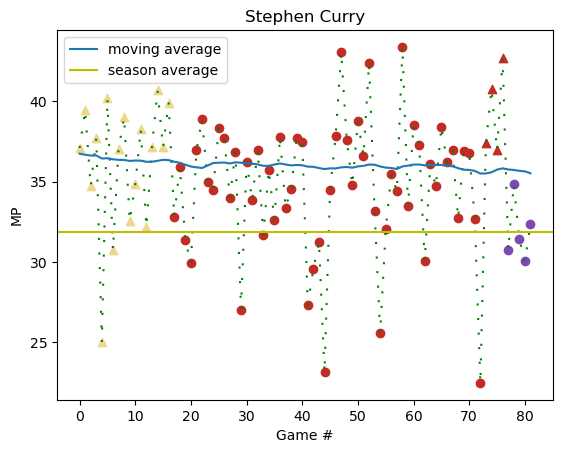

In [45]:
gl.graph_stat('Stephen Curry','MP',window=100,lines=pp_lines)

In [47]:
gl.game_log.loc[(gl.game_log.player=='Stephen Curry') & (gl.game_log.series != 5)]

,player,G,date,series,team,H/A,opp,G#,W/L,GS,...,TOV,PF,PTS,GmSc,+/-,pos,KM,season,age,rest
31850,Stephen Curry,1,2013-04-20,WC1,GSW,0,DEN,1.0,-2,1,...,5,2,19,11.5,8.0,PG,15,2013,5,5.0
31851,Stephen Curry,2,2013-04-23,WC1,GSW,0,DEN,2.0,14,1,...,1,4,30,30.1,15.0,PG,15,2013,5,3.0
31852,Stephen Curry,3,2013-04-26,WC1,GSW,1,DEN,3.0,2,1,...,3,4,29,27.2,13.0,PG,15,2013,5,3.0
31853,Stephen Curry,4,2013-04-28,WC1,GSW,1,DEN,4.0,14,1,...,2,4,31,30.0,21.0,PG,15,2013,5,2.0
31854,Stephen Curry,5,2013-04-30,WC1,GSW,0,DEN,5.0,-7,1,...,2,5,15,8.4,-3.0,PG,15,2013,5,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31983,Stephen Curry,22,2022-06-16,FIN,GSW,0,BOS,6.0,13,1,...,2,4,34,30.2,8.0,PG,15,2022,5,3.0
32040,Stephen Curry,1,2023-04-15,WC1,GSW,0,SAC,1.0,-3,1,...,5,3,30,17.8,11.0,PG,15,2023,5,6.0
32041,Stephen Curry,2,2023-04-17,WC1,GSW,0,SAC,2.0,-8,1,...,5,2,28,16.5,3.0,PG,15,2023,5,2.0
32042,Stephen Curry,3,2023-04-20,WC1,GSW,1,SAC,3.0,17,1,...,1,4,36,27.7,24.0,PG,15,2023,5,3.0
